# Predicting State Transition of Liver Transplant Patients using Neural Networks with the CORAL framework

## Does body composition play a role in liver transplant outcomes?

### Reading in the data

In [1]:
#!pip install boxsdk

In [2]:
# Import two classes from the boxsdk module - Client and OAuth2
from boxsdk import Client, OAuth2

import pandas as pd
import io
import numpy as np
import seaborn as sns
import matplotlib as plt

#displaying not in scientific notation for readability
pd.options.display.float_format = '{:.5f}'.format

# Read app info from text file
with open('app.cfg', 'r') as app_cfg:
    CLIENT_ID = app_cfg.readline()
    CLIENT_SECRET = app_cfg.readline()
    ACCESS_TOKEN = app_cfg.readline()

In [3]:
class BOXFile:
 def __init__(self, CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN):
     self._oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)
     self._client = Client(self._oauth2)
     self._file = None
 
 def GetUserInfo(self):
     my = self._client.user(user_id='me').get()

 def GetFile(self, fileID):
     self._file = self._client.file(fileID)
     return(self._file.content())

In [4]:
boxfile = BOXFile(CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN)
csvFile = boxfile.GetFile('936748103348').decode("utf-8")
ioFile = io.StringIO(csvFile)

In [5]:
df = pd.read_csv(filepath_or_buffer = ioFile, delimiter = ",")
df.head()

,age,height,ascites_yn,he,race,sex,smoker,cit,etiology,meld,...,htn,dm,ckd,copd,cad,ctd,prev_state,time,state,patient_mrn
0,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,ICU/Vent,1,ICU/Vent,3156866
1,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,ICU/Vent,2,ICU/Vent,3156866
2,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,ICU/Vent,3,ICU/Vent,3156866
3,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,ICU/Vent,4,ICU/Vent,3156866
4,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,ICU/Vent,5,ICU/Vent,3156866


In [6]:
df.shape

(39668, 28)

In [7]:
df.isna().sum()

age                0
height             0
ascites_yn         0
he                 0
race               0
sex                0
smoker             0
cit                0
etiology           0
meld               0
acr                0
surgeryduration    0
sma00              0
vat00              0
sat00              0
s_mhu00            0
v_fhu00            0
sa_thu00           0
htn                0
dm                 0
ckd                0
copd               0
cad                0
ctd                0
prev_state         0
time               0
state              0
patient_mrn        0
dtype: int64

### Terminating follow-up after death

Because death is an absorbing state, I want to remove all observations after death for patients who die. 

In [8]:
df = df[df['prev_state'] != 'Dead']

### 90 Day Period

Because I don't have the cause of death for patients in the study, the longer post liver transplant the less I can assume that a patient dying is caused by the liver transplant. Also after 90 all patients are out of the hospital and either at home/in a facility or have died. I need to filter the data to only include days in the 90 period after a patient's liver transplant surgery.

In [9]:
df = df[df['time'] < 91]

In [10]:
df.shape

(37501, 28)

###  Convert Categorical variables

Because neural networks can only handle numeric inputs, I need to convert categorical variables to numeric values.

In [11]:
df['state'].replace(["Home/IPR", "Hospital", "ICU/Vent", "Dead"],
                        [0, 1, 2, 3], inplace=True)
          
df['prev_state'].replace(["Home/IPR", "Hospital", "ICU/Vent"],
                        [0, 1, 2], inplace=True)                     

In [12]:
df.head()

,age,height,ascites_yn,he,race,sex,smoker,cit,etiology,meld,...,htn,dm,ckd,copd,cad,ctd,prev_state,time,state,patient_mrn
0,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,2,1,2,3156866
1,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,2,2,2,3156866
2,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,2,3,2,3156866
3,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,2,4,2,3156866
4,57,162.60000,2,2,1,2,1,9.07000,5,27,...,2,2,2,1,1,1,2,5,2,3156866


In [13]:
df.dtypes

age                  int64
height             float64
ascites_yn           int64
he                   int64
race                 int64
sex                  int64
smoker               int64
cit                float64
etiology             int64
meld                 int64
acr                  int64
surgeryduration      int64
sma00              float64
vat00              float64
sat00              float64
s_mhu00            float64
v_fhu00            float64
sa_thu00           float64
htn                  int64
dm                   int64
ckd                  int64
copd                 int64
cad                  int64
ctd                  int64
prev_state           int64
time                 int64
state                int64
patient_mrn          int64
dtype: object

In [14]:
df.shape

(37501, 28)

## Looking at Correlations

Before modeling, I want to look at the correlation between different variables in my data set.

<AxesSubplot:>

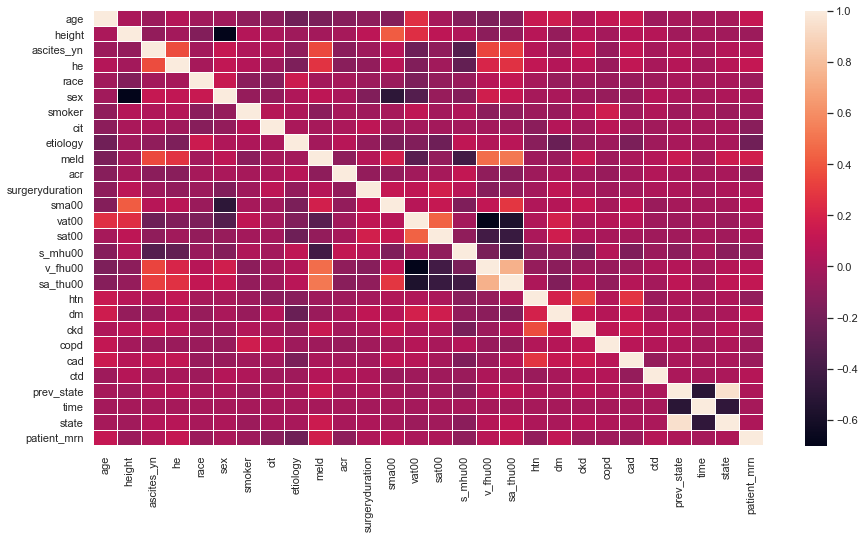

In [15]:
corr = df.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, 
xticklabels=corr.columns.values,
yticklabels=corr.columns.values,
           linewidths=.005)

In [16]:
df['state'].corr(df['prev_state'])

0.9523992624169789

### Data Splitting

Data cleaning, feature selection, imputing missing values and data processing have all been done in R before reading the data into this notebook. The data however, is not split into training and testing or scaled for modeling.

I need to split the data into separate training and testing data sets. Because the data originally was one observation per patient and I want to make sure all observations for each patient are in the same dat set, I will split the data based on patient_mrn.

In [17]:
from sklearn.model_selection import train_test_split

patients = df['patient_mrn'].unique()

train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state = 22)

In [18]:
print(train_patients.shape)
print(test_patients.shape)

(337,)
(85,)


In [19]:
train = df[df["patient_mrn"].isin(train_patients)]
test = df[df["patient_mrn"].isin(test_patients)]

print(train.shape)
print(test.shape)

(29972, 28)
(7529, 28)


In [20]:
X_train = train.drop(['state'], axis = 1)
X_test = test.drop(['state'], axis = 1)
y_train = train[['state']]
y_test = test[['state']]

y_test = y_test['state'].to_numpy()
y_train = y_train['state'].to_numpy()

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(29972, 27)
(7529, 27)
(29972,)
(7529,)


### Data Scaling

Now that I have training and testing data sets, I need to scale the features to be between 0 and 1 in the training set and then use these scaling parameters to scale the test set. 

In [22]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
scaler = MinMaxScaler()

# transform features (X)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

In [23]:
#!pip install coral-ordinal

In [24]:
import tensorflow as tf
print("Tensorflow version", tf.__version__)

import coral_ordinal as coral
print("CORAL Ordinal version:", coral.__version__)

Tensorflow version 2.7.0
CORAL Ordinal version: 0.1.8


### Baseline Model

As a baseline the first model I want to create is a single dense layer with the same dimensions of the number of parameters input. This is essentially equivalent to a basic classification model using logistic regression except I am converting the last layer to the number of classes in my outcome (4) and swapping out the loss function for the coral ordinal loss. I will build deeper models but this will be my baseline for a simple model for comparison.

In [25]:
def baseline_model(num_classes):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(27,input_shape=(27,)))
    model.add(coral.CoralOrdinal(num_classes = num_classes))    

    return model

In [26]:
base_model = baseline_model(4)

In [27]:
base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05),
              loss = coral.OrdinalCrossEntropy(num_classes = 4),
              metrics = [coral.MeanAbsoluteErrorLabels()])

In [28]:
history = base_model.fit(X_train, y_train, epochs = 5,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)])

Epoch 1/5
937/937 [==============================] - 2s 921us/step - loss: 0.1228 - mean_absolute_error_labels: 0.0434
Epoch 2/5
937/937 [==============================] - 1s 873us/step - loss: 0.0936 - mean_absolute_error_labels: 0.0301
Epoch 3/5
937/937 [==============================] - 1s 843us/step - loss: 0.0934 - mean_absolute_error_labels: 0.0299
Epoch 4/5
937/937 [==============================] - 1s 860us/step - loss: 0.0961 - mean_absolute_error_labels: 0.0311
Epoch 5/5
937/937 [==============================] - 1s 835us/step - loss: 0.0930 - mean_absolute_error_labels: 0.0288


### Baseline Model Evaluation

In [29]:
base_model.evaluate(X_test, y_test)

236/236 [==============================] - 0s 663us/step - loss: 0.0946 - mean_absolute_error_labels: 0.0232


[0.09458605945110321, 0.023172669112682343]

In [30]:
# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
base_ordinal_logits = base_model.predict(X_test)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
base_tensor_probs = coral.ordinal_softmax(base_ordinal_logits)

# Convert the tensor into a pandas dataframe.
base_probs_df = pd.DataFrame(base_tensor_probs.numpy())

base_probs_df.shape

(7529, 4)

Here we can see for each observation, the probability of the patient being in each state. I have also printed the first 10 rows the of actual state in the test set below. You can see that in choosing the state with the highest probability, for the first observation the predicted state would be 2 (ICU/VENT) and the actual outcome in the test set it also 2 therefore my model accurately predicted the first observation.

In [31]:
base_probs_df.head(10)

,0,1,2,3
0,0.00002,0.14251,0.85697,0.00050
1,0.00002,0.14616,0.85333,0.00049
2,0.00002,0.14989,0.84962,0.00048
3,0.04871,0.94893,0.00237,0.00000
4,0.99189,0.00811,0.00000,0.00000
5,0.99213,0.00787,0.00000,0.00000
6,0.99235,0.00765,0.00000,0.00000
7,0.99257,0.00742,0.00000,0.00000
8,0.99279,0.00721,0.00000,0.00000
9,0.99300,0.00700,0.00000,0.00000


In [32]:
y_test[0:10]

array([2, 2, 1, 0, 0, 0, 0, 0, 0, 0])

Now I want to look at some different metrics to see how well my model performed on the test set. First I look at the overall accuracy of the percentage of outcomes my model predicted correctly. 

Using the method of classification, I would just take the overall percentage of observations my model predicted accurately. As shown below this measure is 97% which is really great. However, because my outcomes are ordinal, there is a larger penalty for some erros versus others which is not measured in this metric.

In [33]:
# Evaluate accuracy and mean absolute error
base_labels = base_probs_df.idxmax(axis = 1)
print("Accuracy of label (normal classification method):", np.mean(base_labels == y_test))

Accuracy of label (normal classification method): 0.9776862797184221


The COinsisten RAnk Logits (CORAL) method addresses rank inconsistency and therefore I will use their version of metrics instead. Rather than choosing the outcome as the highest probable state, I take the probability of being greater than each state (logit-based cumulative probs) and sum each that is higher than 0.5. For example, if the probability not being home, P(Y > 0), is greater than 0.5 AND P(Y > 1) > 0.5 but P(Y > 2) < 0.5, the predicted outcome would be 2. 

The accuracy using the cumulative probabilities, is 97.5%.

In [34]:
from scipy import special

# Compare to logit-based cumulative probs
base_cum_probs = pd.DataFrame(base_ordinal_logits).apply(special.expit)
base_cum_probs.head()

,0,1,2
0,0.99998,0.85747,0.00050
1,0.99998,0.85382,0.00049
2,0.99998,0.85009,0.00048
3,0.95129,0.00237,0.00000
4,0.00811,0.00000,0.00000


In [35]:
# Calculate the labels using the style of Cao et al.
base_labels = base_cum_probs.apply(lambda x: x > 0.5).sum(axis = 1)
print("Accuracy of label:", np.mean(base_labels == y_test))

Accuracy of label: 0.9776862797184221


I have also calculated the Mean absolute error and the root mean squared label error. For ordinal labels, these measures take into account the fact that some errors are worse than others. For example, predicting someone is at home and healthy when they actually died is much worse than predicting someone is at home and healthy when they are in fact in the hospital. Ordinal outcomes that are more 2 levels apart will have an error of 2 for an incorrect prediction and an incorrect prediction of one level difference in state will have an error of 1 for that observation.

In [36]:
print("Mean absolute label error:", np.mean(np.abs(base_labels - y_test)))
print("Root mean squared label error:", np.sqrt(np.mean(np.square(base_labels - y_test))))

Mean absolute label error: 0.023243458626643645
Root mean squared label error: 0.16010688420895092


In [37]:
# Review how absolute error is calculated for ordinal labels
pd.DataFrame({"true": y_test, "pred": base_labels, "abs": base_labels - y_test}).head()

,true,pred,abs
0,2,2,0
1,2,2,0
2,1,2,1
3,0,1,1
4,0,0,0


In [38]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                756       
                                                                 
 coral_ordinal (CoralOrdinal  (None, 3)                30        
 )                                                               
                                                                 
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________


## Feature Importance

Now that I have a model that has great predictive performance, I want to understand the importance of the features I am inputting into the model. A main goal of this analysis is to understand how body composition affects outcomes of liver transplants and to do that I need to understand if any of the body composition variables are important in my model.

First, since I only have one dense layer in my model, I can look at the weights at that layer to get an understanding of how they are distributed. There are 35 weights, the same number as inputs into my model as this is a fully connected layer, but unfortunately these values don't do me much good as I don't know which features go into each weight.

In [39]:
for layer in base_model.layers:
    weights = layer.get_weights()

In [40]:
weights[0]

array([[-0.0337979 ],
       [-0.1343209 ],
       [-0.19700332],
       [ 0.05158802],
       [ 0.01052974],
       [-0.8280792 ],
       [ 0.40343413],
       [ 0.13210405],
       [-0.0879375 ],
       [-0.09944673],
       [-0.09046238],
       [ 0.10700209],
       [-0.02195854],
       [-0.11952703],
       [ 0.05298295],
       [ 0.01785793],
       [-0.04884078],
       [ 0.06244642],
       [ 0.00306787],
       [-0.06669185],
       [-0.10383116],
       [-0.09969714],
       [ 0.07121053],
       [-0.44089738],
       [-0.04053343],
       [ 0.06644452],
       [-0.0098881 ]], dtype=float32)

From the correlation matrix above, I can already see that there isn't a strong correlation between state and any of the body composition variables. This however is a correlation matrix over the entire dataset of 90 days per patient. To understand importance of features, I am going to hold time constant at day 10.

<AxesSubplot:>

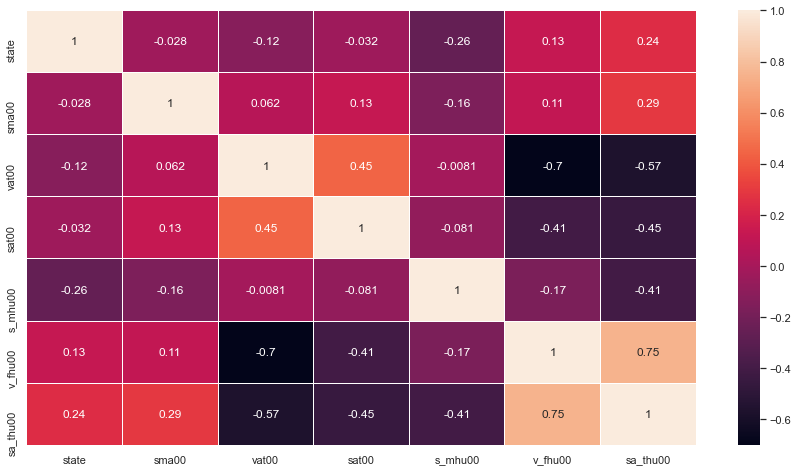

In [41]:
df_10 = df[df['time'] == 10]
df_10_body = df_10[['state', 'sma00', 'vat00', 'sat00', 's_mhu00', 'v_fhu00', 'sa_thu00']]

corr = df_10_body.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, 
xticklabels=corr.columns.values,
yticklabels=corr.columns.values,
           linewidths=.005,
           annot=True)

After filtering for only body composition variables, it is a bit easier to see how they correlate with a patient's state at day 10 post liver transplant surgery. Here we can see that state doesn't correlate highly with an body composition variable. The highest correlation is with skeletal muscle density (s_mhu00) which is a negative correlation of -0.27. This is still a fairly weak correlation. 

I want to do the same analysis at day 5 and at day 30 to see if the trends change with a different time period.

<AxesSubplot:>

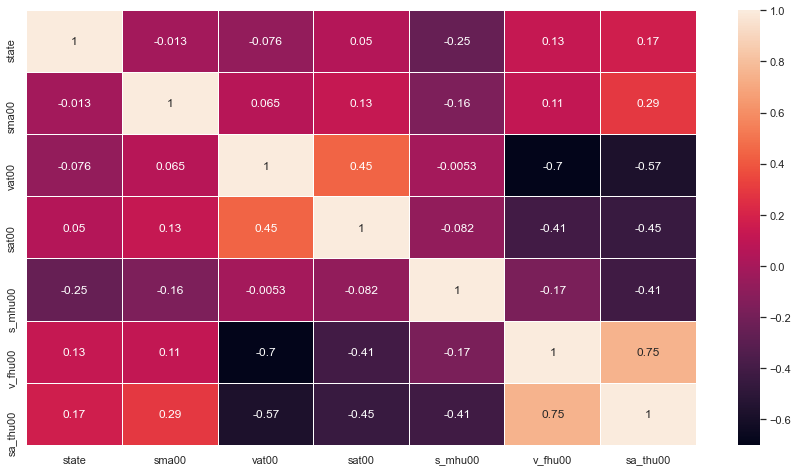

In [42]:
df_5 = df[df['time'] == 5]
df_5_body = df_5[['state', 'sma00', 'vat00', 'sat00', 's_mhu00', 'v_fhu00', 'sa_thu00']]

corr = df_5_body.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, 
xticklabels=corr.columns.values,
yticklabels=corr.columns.values,
           linewidths=.005,
           annot=True)

<AxesSubplot:>

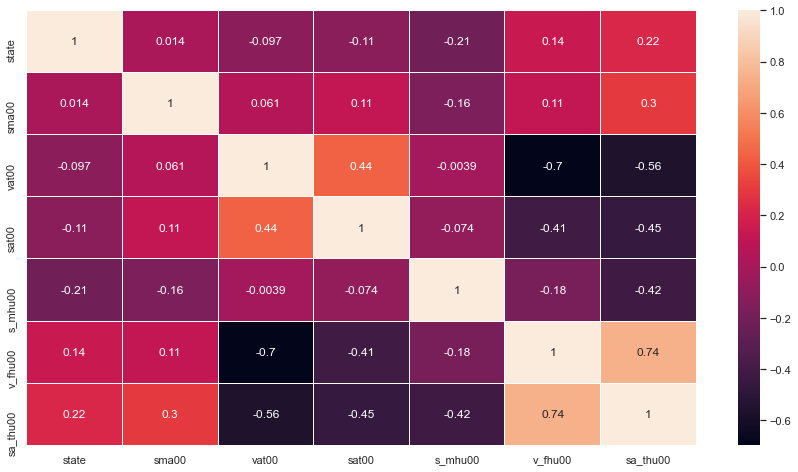

In [43]:
df_30 = df[df['time'] == 30]
df_30_body = df_30[['state', 'sma00', 'vat00', 'sat00', 's_mhu00', 'v_fhu00', 'sa_thu00']]

corr = df_30_body.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, 
xticklabels=corr.columns.values,
yticklabels=corr.columns.values,
           linewidths=.005,
           annot=True)

The correlations do not change very much for each of the different time periods. There are slight differences, but with only 422 patients this can easily be due to sample variation and is not by any significant amount.

In [44]:
print(test.shape, base_probs_df.shape)

(7529, 28) (7529, 4)


In [45]:
test = test.reset_index(drop=True)
p = pd.concat([test, base_probs_df], axis = 1)
p.head()

,age,height,ascites_yn,he,race,sex,smoker,cit,etiology,meld,...,cad,ctd,prev_state,time,state,patient_mrn,0,1,2,3
0,58,180.34000,1,1,1,1,1,3.85000,3,7,...,1,1,2,1,2,4180402,0.00002,0.14251,0.85697,0.00050
1,58,180.34000,1,1,1,1,1,3.85000,3,7,...,1,1,2,2,2,4180402,0.00002,0.14616,0.85333,0.00049
2,58,180.34000,1,1,1,1,1,3.85000,3,7,...,1,1,2,3,1,4180402,0.00002,0.14989,0.84962,0.00048
3,58,180.34000,1,1,1,1,1,3.85000,3,7,...,1,1,1,4,0,4180402,0.04871,0.94893,0.00237,0.00000
4,58,180.34000,1,1,1,1,1,3.85000,3,7,...,1,1,0,5,0,4180402,0.99189,0.00811,0.00000,0.00000


In [46]:
p.rename({0: 'p_home', 1: 'p_hosp', 2: 'p_icu', 3: 'p_dead'}, axis=1, inplace=True)
p['p_not_home'] = p["p_hosp"] + p["p_icu"] + p["p_dead"]

In [47]:
p_home_avg = p[['time', 'p_home']].groupby(['time']).mean()

<AxesSubplot:title={'center':'Average Probability a Patient is at Home/IPR'}, xlabel='time'>

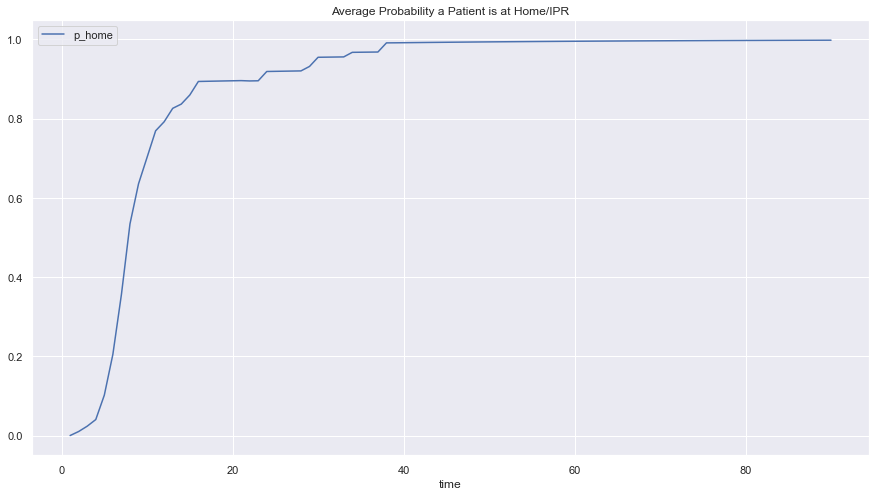

In [48]:
p_home_avg.reset_index().plot(x='time', y='p_home', title = "Average Probability a Patient is at Home/IPR")

<AxesSubplot:title={'center':'Average Probability a Patient is not ICU/Vent or Dead'}, xlabel='time'>

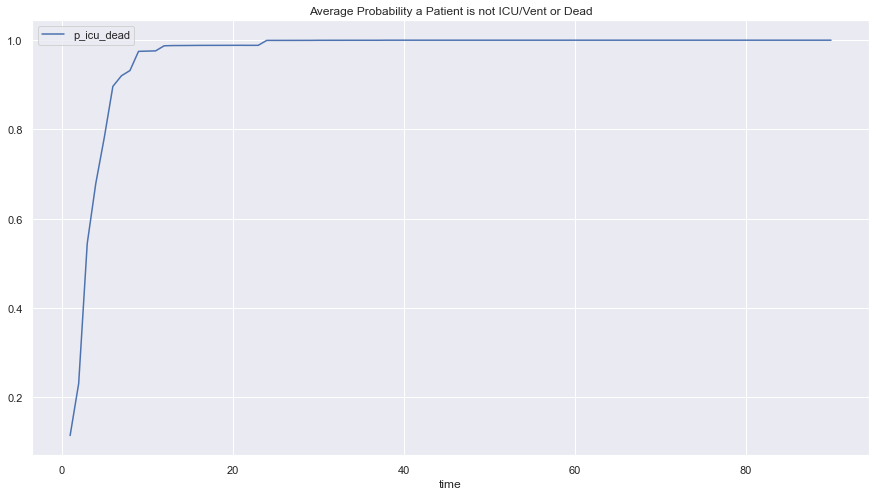

In [49]:
p['p_icu_dead'] = p['p_home'] + p['p_hosp']
p_not_icu_dead_avg = p[['time', 'p_icu_dead']].groupby(['time']).mean()
p_not_icu_dead_avg.reset_index().plot(x='time', y='p_icu_dead', title = "Average Probability a Patient is not ICU/Vent or Dead")

In [50]:
boxfile = BOXFile(CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN)
csvFile = boxfile.GetFile('944898689599').decode("utf-8")
ioFile = io.StringIO(csvFile)

phome = pd.read_csv(filepath_or_buffer = ioFile, delimiter = ",")
phome.head()

,time,state=Home/IPR
0,1,0.00026
1,2,0.02804
2,3,0.07228
3,4,0.10511
4,5,0.17432


In [51]:
p_home = p_home_avg.join(phome.set_index('time'))
p_home = p_home.rename(columns={"p_home": "NN Model", "state=Home/IPR": "PO Model"})
p_home.reset_index(inplace=True)
p_home.head()

,time,NN Model,PO Model
0,1,0.00002,0.00026
1,2,0.01020,0.02804
2,3,0.02363,0.07228
3,4,0.04035,0.10511
4,5,0.10198,0.17432


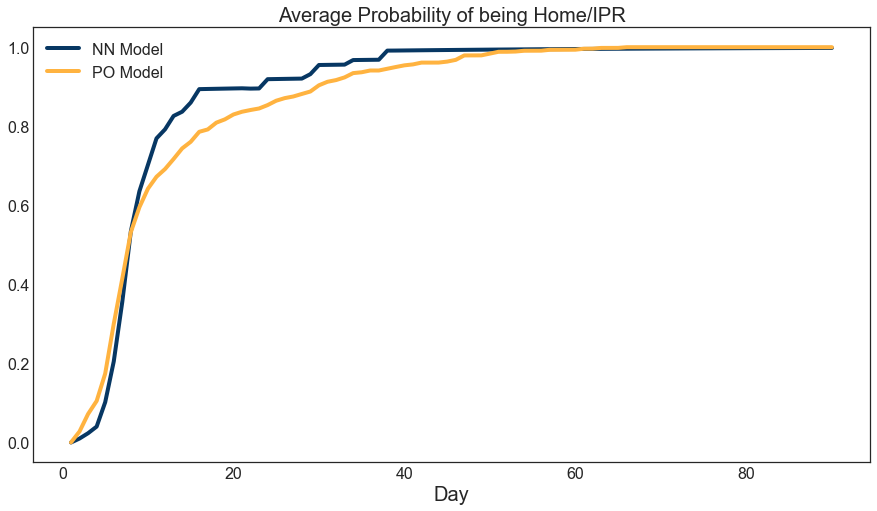

In [73]:
plt.style.use('ggplot')
plt.style.use('seaborn-white')
p = p_home.plot(x="time", y=["NN Model", "PO Model"], 
            title = "Average Probability of being Home/IPR", xlabel = "Day", 
            color = ["#073763", "#ffb340"], linewidth=4, fontsize = 16)
p.legend(prop={'size': 16})
p.xaxis.label.set_size(20)
p.title.set_size(20)